# import packages

In [1]:
import os
import pandas as pd
import random
import time
import shutil
import requests
import matplotlib.pyplot as plt
from pyinaturalist import *
from PIL import Image
import numpy as np
from typing_extensions import Counter

Optional: get place code for limiting search spatially

In [2]:
response = get_places_autocomplete(q='France')
pprint({p['id']: p['name'] for p in  response['results']})

{
    6753: 'France',
    11367: 'Fort-de-France',
    10577: 'Île-de-France',
    104968: 'Francesti',
    108129: 'Frances Baard',
    30182: 'Yvelines',
    38738: 'Fort-de-France',
    99546: 'Val-de-Marne',
    30178: 'Seine-Saint-Denis',
    99548: 'Hauts-de-Seine'
}


# Initialize function to scrape images from Inaturalist

In [5]:
# Scrape Images and Metadata

# Here we make a function to save photos of a target species locally and save necessary metada: latitude, longitude, observation ID, photo IDs, Photo urls. Metadata is saved as a dictionary and photos are saved in a directory specified by the user.
# Metadata example:
# observation_id   latitude  longitude  observation_data  photo_ids  \
# 0       259323505  57.736160  10.629406 date  [465488543]
# 1       259193935  48.037273  11.509971 date  [465220887]
# 2       258982331  49.385485  19.790977 date  [464790765]
# 3       258835093  46.517517   9.908752 date  [464493974]
# 4       258811645  52.674268   6.516881 date  [464445739]
#
#                                               photos
# 0  [https://inaturalist-open-data.s3.amazonaws.co...
# 1  [https://inaturalist-open-data.s3.amazonaws.co...
# 2  [https://static.inaturalist.org/photos/4647907...
# 3  [https://static.inaturalist.org/photos/4644939...
# 4  [https://static.inaturalist.org/photos/4644457...

# Parameters
output_dir = "/mnt/c/Users/pdeschepper/Desktop/"
max_accuracy = 100000
record_limiter = 10

def scrape_inaturalist_images(species_name):
    """Scrape images and metadata for a target species from iNaturalist."""
    observations = []
    page = 1
    per_page = 30

    while len(observations) < record_limiter:
        print(f"Fetching page {page}...") # Added for debugging/tracking
        try:
            response = get_observations(
                taxon_id=species_name,
                photos=True,
                captive=False,
                geo=True,
                # place_id=6753, # Set this to a numeric value representing your region (optional, see above)
                identified=True,
                geoprivacy='open',
                acc_below=max_accuracy,
                page=page,
                per_page=per_page
            )
        
        except requests.exceptions.HTTPError as e:
            # Check specifically for the 429 error
            if '429' in str(e):
                print("🚨 Rate limit hit (429)! Pausing for 10 seconds...")
                time.sleep(10) # Wait a minute if severely throttled
                continue # Retry the same page
            else:
                # Handle other HTTP errors
                print(f"An unexpected HTTP error occurred: {e}")
                break

        # Check for empty results on a page, which might indicate the end
        if not response.get('results'):
            break

        # Add observations from current page
        observations.extend(response.get('results', []))
        
        print(f"  -> Collected {len(observations)} of {record_limiter} so far.")

        # Check for exit conditions
        if response.get('page') == response.get('pages') or len(observations) >= record_limiter:
            break

        # Increment page for next iteration
        page += 1
        
        # Add a delay between API calls
        time.sleep(2) # Pause for 2 seconds to respect API limits

    # Limit records to record_limiter if exceeded
    observations = observations[:record_limiter]

    # Ensure the output directory exists and clear if not empty
    if os.path.exists(output_dir) and os.listdir(output_dir):
        # Only remove files if they match the expected pattern to be safe
        for file in os.listdir(output_dir):
            if file.endswith((".jpg", ".csv")):
                 os.remove(os.path.join(output_dir, file))
    else:
        os.makedirs(output_dir, exist_ok=True)


    # Process observations and store metadata
    metadata = []
    # Use requests.Session for efficient downloading
    s = requests.Session() 
    
    for obs in observations:
        observation_id = obs.get('id', None)
        latitude = obs.get('geojson', {}).get('coordinates', [None, None])[1]
        longitude = obs.get('geojson', {}).get('coordinates', [None, None])[0]
        observation_date = obs.get('time_observed_at', obs.get('observed_on', None))  
        photos = obs.get('photos', [])

        # Collect high-resolution photo URLs and IDs
        photo_urls = [photo.get('url', "").replace("square", "original") for photo in photos]
        photo_ids = [photo.get('id', None) for photo in photos]

        # Download and save photos
        for i, img_url in enumerate(photo_urls):
            photo_id = photo_ids[i]
            img_path = os.path.join(output_dir, f"{photo_id}.jpg")
            
            # Skip if URL is empty or None
            if not img_url:
                continue
                
            try:
                # Use the session for downloading
                img_response = s.get(img_url, timeout=10)
                img_response.raise_for_status() # Check for bad status codes (like 404)
                
                with open(img_path, 'wb') as f:
                    f.write(img_response.content)
                
                # Add a smaller delay between photo downloads if needed, but usually not required
                # time.sleep(0.5) 
            except Exception as e:
                print(f"Error downloading photo {photo_id} from {img_url}: {e}")
                continue

        # Append metadata for the observation
        metadata.append({
            "observation_id": observation_id,
            "latitude": latitude,
            "longitude": longitude,
            "observation_date": observation_date,
            "photo_ids": photo_ids,
            "photos": photo_urls
        })
        
    return metadata

# Use scraping function

In [8]:
# Usage
species_name = "30929" # Vipera aspis
metadata = scrape_inaturalist_images(species_name)

# Convert metadata to a DataFrame for easier visualization
df = pd.DataFrame(metadata)

# Save metadata to a CSV file
metadata_path = os.path.join(output_dir, "metadata.csv")
df.to_csv(metadata_path, index=False)

# Display the DataFrame
print(df.head())
len(df)


Fetching page 1...
  -> Collected 30 of 10 so far.
   observation_id   latitude  longitude           observation_date  \
0       329690786  43.747375   2.571512  2025-03-14 16:06:12+01:00   
1       329633339  45.995967   7.121564  2010-06-28 11:14:00+02:00   
2       329357764  45.452094   5.290907  2019-08-16 11:15:57+02:00   
3       329124560  46.302360   7.885959  2015-11-05 16:29:00+01:00   
4       328121178  42.977585   1.966561  2025-02-15 13:42:41+01:00   

                           photo_ids  \
0                        [597675163]   
1                        [597558957]   
2                        [597004834]   
3  [596534075, 596534084, 596534224]   
4                        [594514460]   

                                              photos  
0  [https://inaturalist-open-data.s3.amazonaws.co...  
1  [https://inaturalist-open-data.s3.amazonaws.co...  
2  [https://inaturalist-open-data.s3.amazonaws.co...  
3  [https://inaturalist-open-data.s3.amazonaws.co...  
4  [https://

10

# Open a photo and check size


Width: 2048, Height: 1365


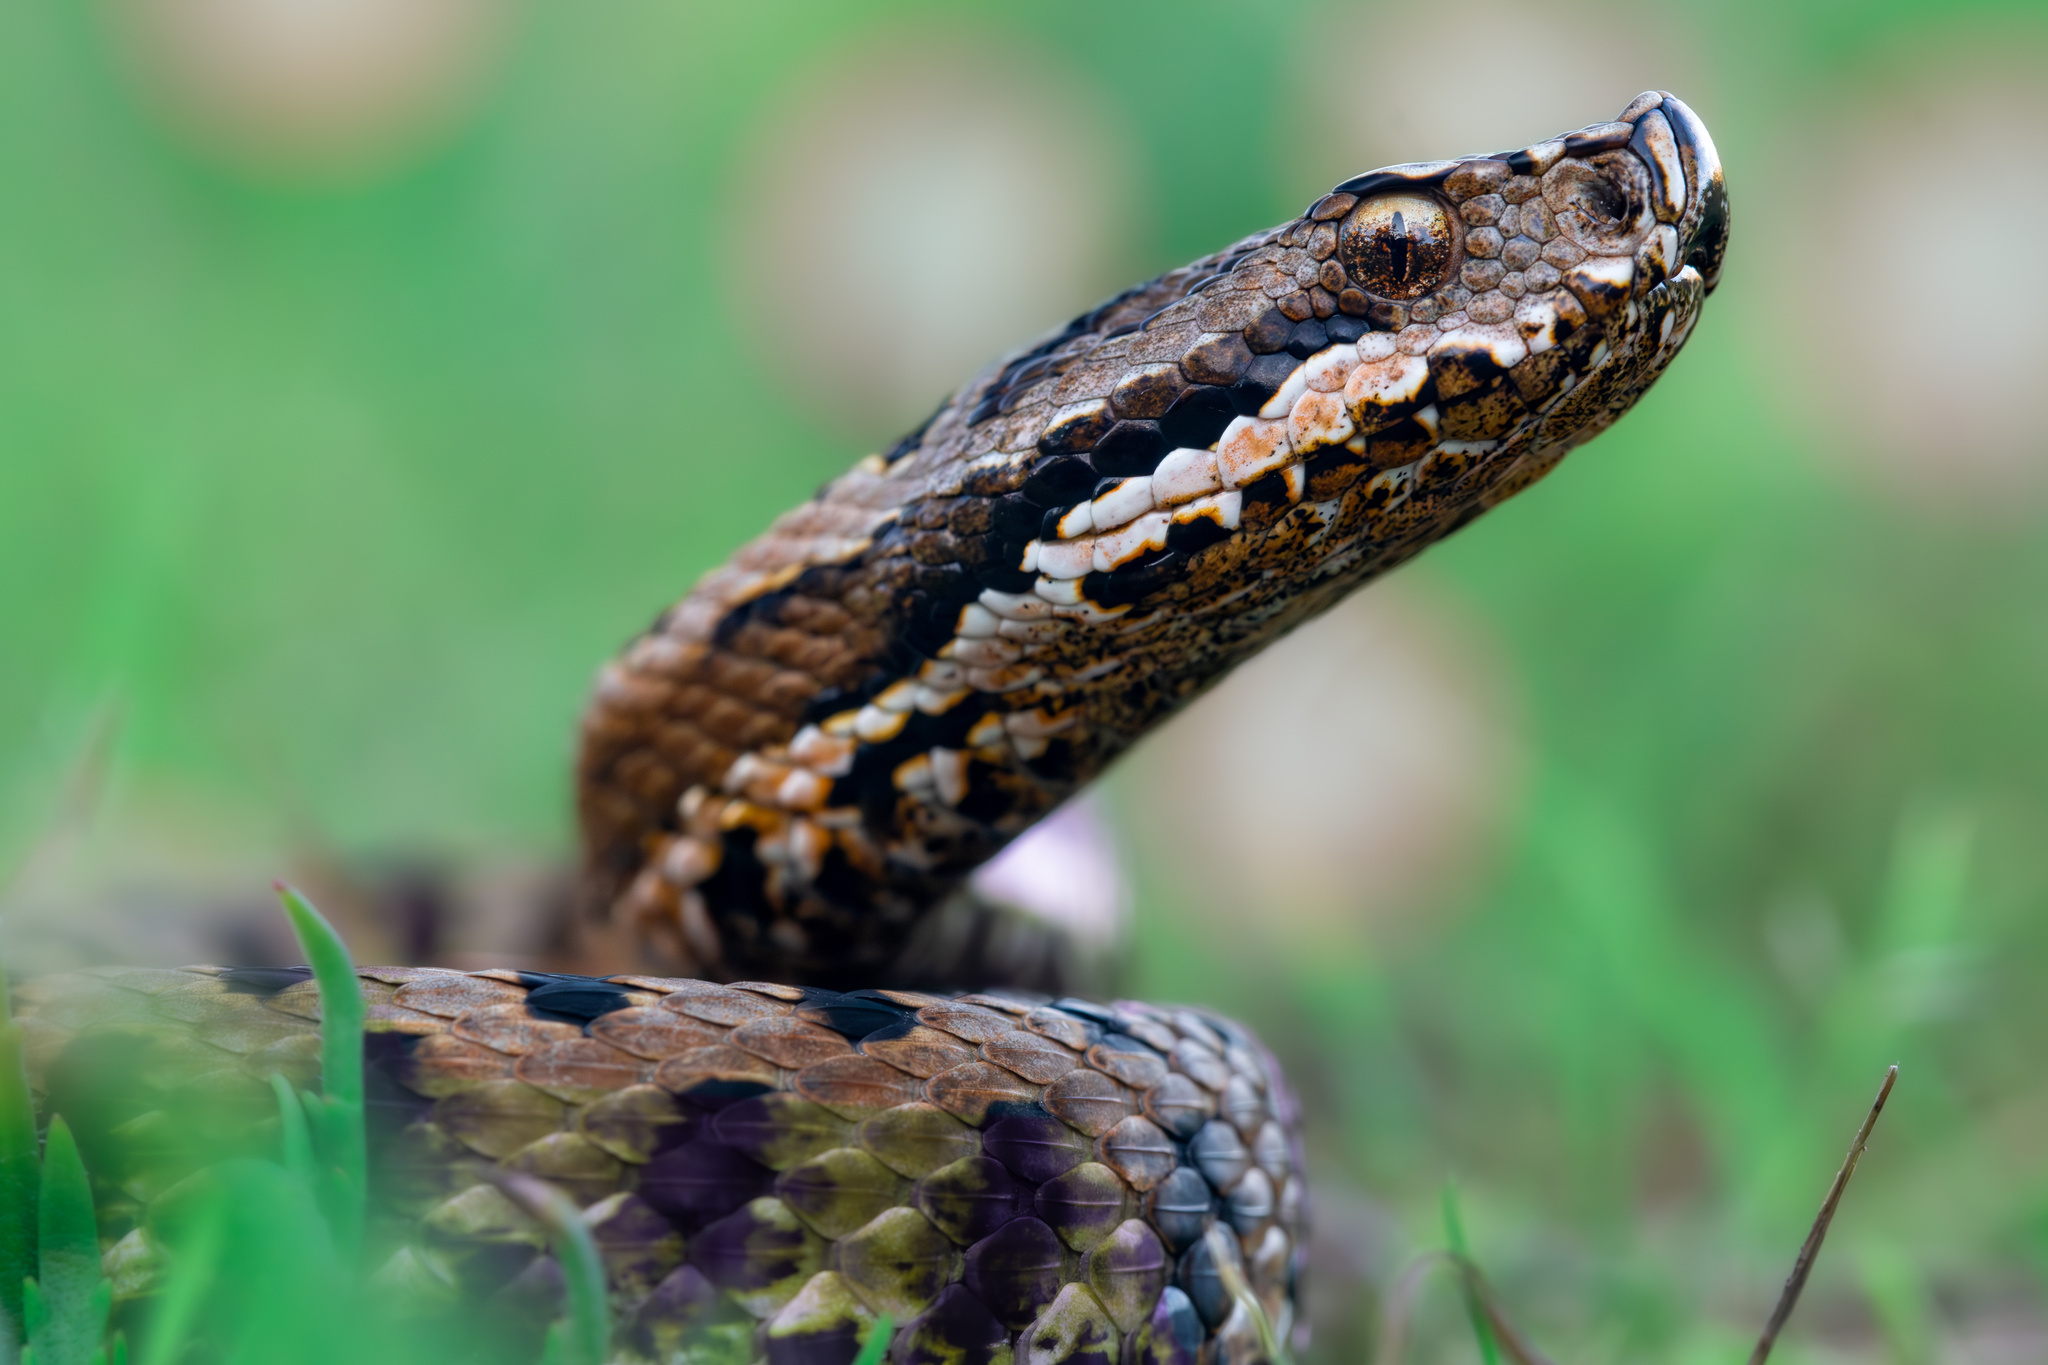

['592287799.jpg', '592558160.jpg', '592636959.jpg', '592774976.jpg', '593673620.jpg', '594514460.jpg', '596534075.jpg', '596534084.jpg', '596534224.jpg', '597004834.jpg', '597558957.jpg', '597675163.jpg', 'comments RZ ms Sistrurus.docx', 'desktop.ini', 'metadata.csv', 'Netflix.lnk', 'Positron-2025.09.0-139-UserSetup.exe', 'rtools45-6608-6492.exe', 'Zoom Workplace.lnk', '~$mments RZ ms Sistrurus.docx']


In [10]:
# Get a list of all image files in the directory
image_files = []
for f in os.listdir(output_dir):
    if os.path.isfile(os.path.join(output_dir, f)):
        image_files.append(f)

# Select a random image file
random_image_file = random.choice(image_files)

# Construct the full path to the random image
random_image_path = os.path.join(output_dir, random_image_file)

# Open the random image
image = Image.open(random_image_path)

# Get dimensions
width, height = image.size
print(f"Width: {width}, Height: {height}")

# Display the image (optional)
display(image)

print(image_files)

# Zip photos (.jpg)

In [11]:
import os
import zipfile

def zip_jpg_files(output_directory, zip_file_name="images.zip"):
    """
    This function zips all the .jpg files in a given directory.

    Args:
        output_directory: The directory where the .jpg files are located.
        zip_file_name: The name of the zip file to be created (default: "images.zip").

    Returns:
        None. It creates a zip file in the output directory.
    """

    # Create the full path for the zip file
    zip_file_path = os.path.join(output_directory, zip_file_name)

    # Open the zip file in write mode ('w')
    with zipfile.ZipFile(zip_file_path, 'w') as zip_file:
        # Go through all the files and folders in the output directory
        for current_folder, subfolders, files in os.walk(output_directory):
            # Check each file in the current folder
            for file_name in files:
                # If the file ends with '.jpg', add it to the zip file
                if file_name.endswith('.jpg'):
                    # Get the full path of the file
                    file_path = os.path.join(current_folder, file_name)

                    # Add the file to the zip file using its original name
                    zip_file.write(file_path, arcname=file_name)

    # Print a message to confirm the zip file creation
    print(f"All .jpg files in '{output_directory}' have been zipped to '{zip_file_name}'")


# Call the zip function
zip_jpg_files(output_dir)

KeyboardInterrupt: 